In [2]:
from __future__ import print_function
import pandapower as pp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stable_baselines
import pickle
from stable_baselines import DDPG
from scipy.stats import wilcoxon
import sys
import copy
sys.path.append('C:\\Users\\vegar\\Dropbox\\Master\\thesis.git')
from  gym_power.envs.active_network_env import ActiveEnv
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook


# I need to see the actions of the agent
The agent activates flexibility to help the net. Need to plot the actions of the agent togeather with solar irradiance and demand at each load.


In [3]:
def stack_columns(df,columns):
    stacked = pd.DataFrame()
    values, labels = [], []
    for col in columns:
        values += list(df[col])
        labels += [col for _ in range(len(df))]
    stacked['Reward'] = values
    stacked[''] = labels
    return stacked
    

In [4]:
def pickle_savefig(fig,figname):
    matplotlib_name = 'figs/' + figname + '_plt.p'
    with open(matplotlib_name,'wb') as f:
        pickle.dump(fig,f)
    fig.savefig('figs/' + figname +'.png')
    
    
    
    

In [5]:
def read_pickle_fig(figname):
    with open('figs/'+figname +'_plt.p', 'rb') as f:
        fig = pickle.load(f)
    return fig

In [6]:
def find_load_names(sol_bus):
    nr_sol = 1
    nr_else = 1
    load_names = []
    for k in range(len(sol_bus)):
        if sol_bus[k]:
            load_names.append('sun {}'.format(nr_sol))
            nr_sol += 1
        else:
            load_names.append('load {}'.format(nr_else))
            nr_else += 1
    return load_names

In [7]:
def calc_hour(start_hour,time_step):
    return (start_hour + time_step) % 24

In [219]:
def simulate_day2(env,model, show_imbalance=False, show_solar=True, show_action=True,
                  show_demand=False,period=25):
    net = env.powergrid
    sol_bus = net.load['bus'].isin(net.sgen['bus'])
    actions = []
    t_steps = []
    flex_loads = []
    sols = []
    obs = env.reset()
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]
    names = find_load_names(sol_bus)
    hues = []
    for t_step in range(1,period):
        
        action,_ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        
        if show_action:
            actions += list(action)
            hues += ['action' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        
        if show_solar:
            actions += list(sol[t_step-1]*np.ones_like(action))
            hues += ['sun' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        if show_imbalance:
            try:
                imbalance = env.calc_balance()/30000
            except AttributeError:
                imbalance = env.calc_imbalance()/30000
            actions += list(imbalance*np.ones_like(action))
            hues += ['imbalance' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            
        if show_demand:
            actions += list(demand[t_step-1]*np.ones_like(action))
            hues += ['demand' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            


    df = pd.DataFrame()
    df['actions'] = actions
    df['steps'] = t_steps
    df['load'] = flex_loads
    df[''] = hues
    return df

In [9]:
def data_from_subplot(ax, imbalance=False):
    actions = ax.lines[3].get_ydata()
    sun = ax.lines[4].get_ydata()
    balance = ax.lines[5].get_ydata()
    oneplot = pd.DataFrame()
    if imbalance:
        oneplot['Energy imbalance'] = balance
    oneplot['Solar irradiance'] = sun
    oneplot['Action'] = actions
    return oneplot

In [10]:
def change_hours(x,start=155):
    return x-start
def change_legend(x):
    if x == 'No agent':
        return 'No action'
    else:
        return x

## Import models

In [11]:
def load_env(model_name='flexible_load_first',seed=9):
#flexible_load_first, overnight, larger_margin_cost, discount_06, flex50

    params_name = model_name +'_params.p'
    model = DDPG.load('models/'+model_name)
    env = ActiveEnv(seed=seed)
    with open('models/' + params_name,'rb') as f:
        params = pickle.load(f)

    env.set_parameters(params)
    model.set_env(env)
    return model, env

In [78]:
model, env = load_env('overnight_reactive',seed=9)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


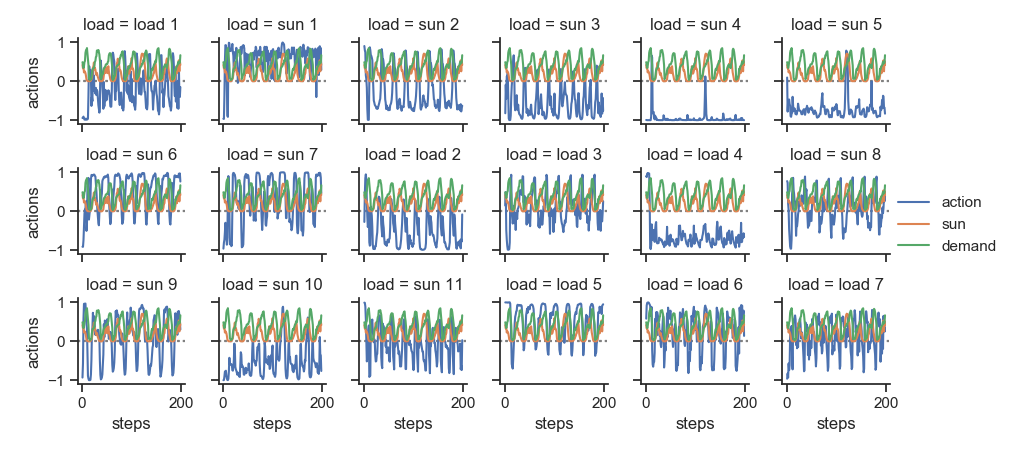

In [220]:
df = simulate_day2(env,model, show_demand=True, period=199)
sns.set(style="ticks")

grid = sns.FacetGrid(df, col="load", hue="",
                     col_wrap=6, height=1.5)

grid.map(plt.axhline, y=0, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [221]:
@interact
def plot_load(ax_nr1=range(18),ax_nr2=range(18),period=(0,200)):
    plot1 = data_from_subplot(grid.axes[ax_nr1],imbalance=True)
    plot2 = data_from_subplot(grid.axes[ax_nr2],imbalance=True)

    fig, axes = plt.subplots(2)
    #axes.set_title(ax.get_title())
    #axes.set_title('Total energy imbalance')
    axes[0].set_xlabel('steps')
    axes[0].axhline(0,c=".5",ls='--')
    axes[1].axhline(0,c=".5",ls='--')
    #axes.set_ylabel('MWh')
    plot1[:period].plot(ax=axes[0])
    plot2[:period].plot(ax=axes[1])
    plt.tight_layout()


interactive(children=(Dropdown(description='ax_nr1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

## See resulting voltages etc

In [42]:
env.powergrid.res_bus

,vm_pu,va_degree,p_kw,q_kvar
0,1.030000,0.000000,-29900.456517,-9086.961999
1,1.009357,-3.664185,11333.733241,2933.480999
2,0.996422,-4.237402,0.000000,0.000000
3,0.975807,-5.144488,330.646468,144.530961
4,0.974814,-5.196491,322.639727,68.400152
5,0.974195,-5.227244,361.806933,115.281155
6,0.973481,-5.262905,262.167977,86.845137
7,0.972465,-5.277896,63.411203,34.208192
8,0.972660,-5.268847,385.352659,92.993465
9,0.972120,-5.286005,311.028317,256.561444


## Max/Min activation in all hours
See effect of letting the agent controll reactive power aswell

In [175]:
period=199
#model, env = load_env(seed=9)
env1 = ActiveEnv(seed=9)
net = env1.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env1.reset()
sol = env1.solar_forecasts
hues = []
env1.set_parameters({'flexibility':0.25,
                   'solar_scale':1.2,
                   'reactive_power':False})
env2 = copy.deepcopy(env1)
env2.set_parameters({'reactive_power':True})
env2.solar_forecasts = env1.solar_forecasts 
env2.demand_forecasts = env1.demand_forecasts
env3 = copy.deepcopy(env1)
env3.do_action = False
legend_map = {0:'Active',1:'- 25 % demand', 2: 'No action'}


action = -np.ones(18)
for t_step in range(1,period):
    for i, env in enumerate([env1, env2, env3]):
        obs, rewards, dones, info = env.step(action)
        voltage = env.powergrid.res_bus.vm_pu
        actions += list(voltage)
        hues += [legend_map[i] for _ in range(len(voltage))]
        t_steps += list(t_step*np.ones_like(v_active))
        flex_loads += list(range(len(v_active)))

df = pd.DataFrame()
df['Voltage [pu]'] = actions
df['Hour'] = t_steps
df['Load'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


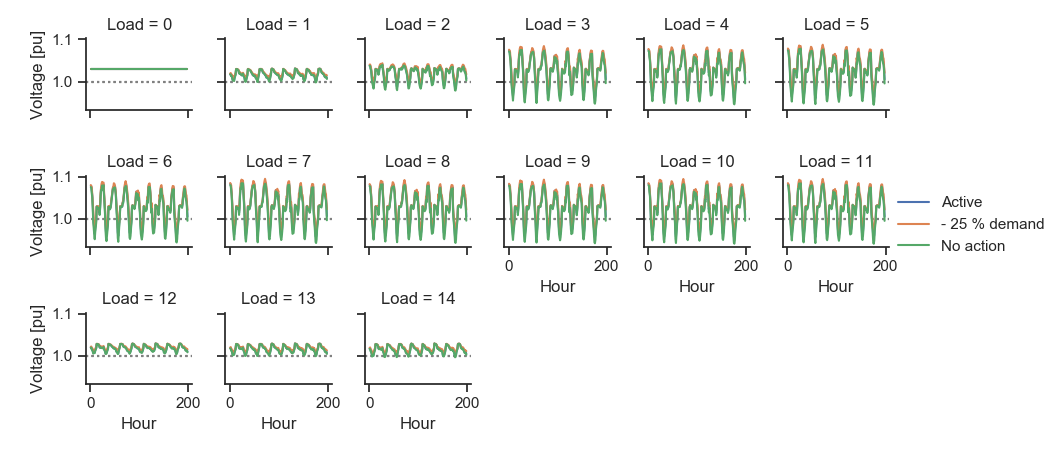

In [176]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Load", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hour", "Voltage [pu]")
grid.add_legend()



In [177]:
@interact
def plot_voltage(bus_nr=list(range(15))[::-1]):
    data = df[df['Load']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hour", y="Voltage [pu]", data=data, ax=ax, hue='')
    

interactive(children=(Dropdown(description='bus_nr', options=(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0…

<IPython.core.display.Javascript object>


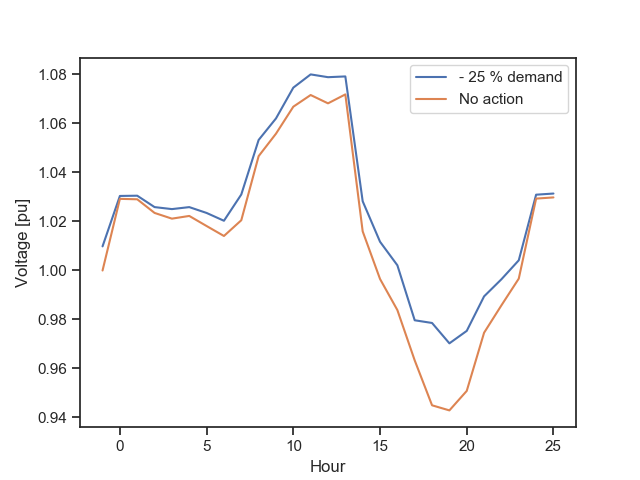

In [178]:
data = df[df['Load']== 8]
data = data[data[''].isin(['No action', '- 25 % demand'])]
data = data[data['Hour'].isin(range(156,183))]
data[''] = data[''].apply(lambda x:change_legend(x))
data['Hour'] = data['Hour'].apply(lambda x:change_hours(x,start=157))
fig, ax = plt.subplots()
sns.lineplot(x="Hour", y="Voltage [pu]", data=data, ax=ax, hue='')

In [180]:
#pickle_savefig(fig,'decrease_demand_voltage')

## Line capacity effect

In [164]:
period=199
#model, env = load_env(seed=9)
env1 = ActiveEnv(seed=9)
net = env1.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env1.reset()
sol = env1.solar_forecasts
hues = []
env1.set_parameters({'flexibility':0.25,
                   'solar_scale':1,
                   'reactive_power':False})
env2 = copy.deepcopy(env1)
env2.set_parameters({'reactive_power':True})
env2.solar_forecasts = env1.solar_forecasts 
env2.demand_forecasts = env1.demand_forecasts
env3 = copy.deepcopy(env1)
env3.do_action = False
legend_map = {0:'Active',1:'+25 % demand', 2: 'No action'}


action = np.ones(18)
#action[[0,10]] = -1

for t_step in range(1,period):

    #action,_ = model.predict(obs)
    action2 = np.ones(18)
    action2[[0,10]] = -1
    
    for i, env in enumerate([env1, env2, env3]):
        obs, rewards, dones, info = env.step(action)
        current = env.powergrid.res_line.loading_percent
        actions += list(current)
        hues += [legend_map[i] for _ in range(len(current))]
        t_steps += list(t_step*np.ones_like(current))
        flex_loads += list(range(len(current)))


df = pd.DataFrame()
df['Line capacity [%]'] = actions
df['Hour'] = t_steps
df['Line'] = flex_loads
df[''] = hues

<IPython.core.display.Javascript object>


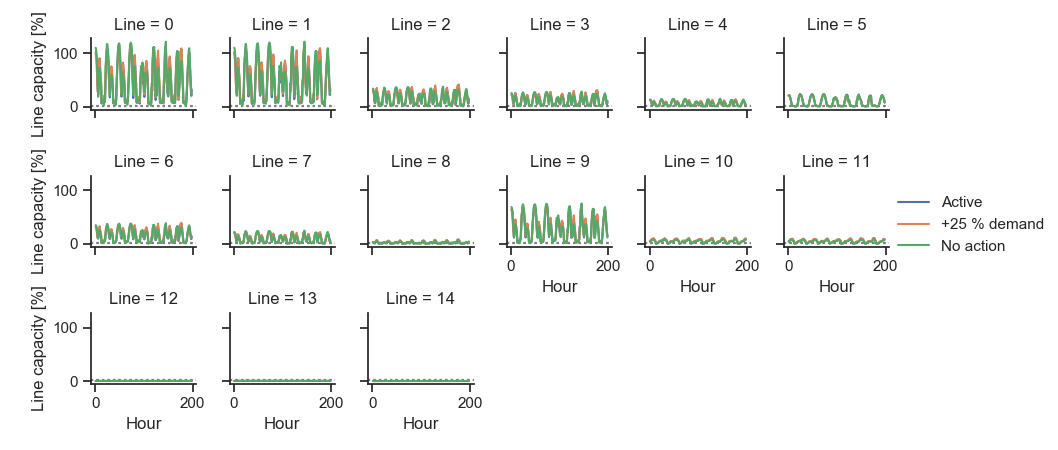

In [165]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Line", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hour", "Line capacity [%]")
grid.add_legend()



In [166]:
@interact
def plot_current(line_nr=list(range(15))):
    data = df[df['Line']== line_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hour", y="Line capacity [%]", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='line_nr', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<IPython.core.display.Javascript object>


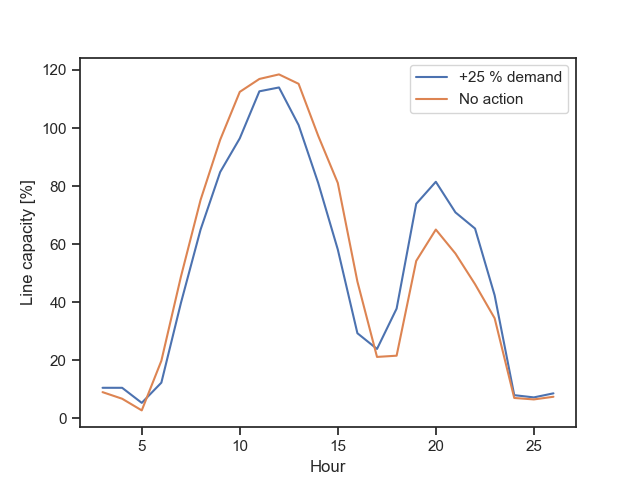

In [167]:
data = df[df['Line']== 0]
data = data[data[''].isin(['No action','+25 % demand'])]
data = data[data['Hour'].isin(range(40,64))]
data['Hour'] = data['Hour'].apply(lambda x:change_hours(x, start=37))
fig, ax = plt.subplots()
sns.lineplot(x="Hour", y="Line capacity [%]", data=data, ax=ax, hue='')
#fig.savefig('figs/increase_demand_current.png')

In [181]:
#pickle_savefig(fig,'increase_demand_current')

In [35]:
print(env.solar_forecasts[:5])
print(env2.solar_forecasts[:5])

[4.31223344e-17 4.31223344e-17 1.18536244e-02 8.62527254e-02
 2.02174315e-01]
[4.31223344e-17 4.31223344e-17 1.18536244e-02 8.62527254e-02
 2.02174315e-01]


In [36]:
print(env.demand_forecasts[0][:5])
print(env2.demand_forecasts[0][:5])

[0.07263449 0.19695374 0.35796542 0.41880813 0.45589402]
[0.07263449 0.19695374 0.35796542 0.41880813 0.45589402]


## See the difference in reward between agent and no-agent

In [59]:
calc_hour(env._episode_start_hour,current_step)

7

In [418]:
for reward in ['current']:
    period=100000
    model, env = load_env('flexible_load_first',seed=9) #seed 5: heavy sun, 9: weak sun
    env.set_parameters({'reward_terms': [reward]})
    rewards, t_steps, hues, hours = [], [], [], []
    obs = env.reset()

    env2 = copy.deepcopy(env)
    env2.do_action = False
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]

    show_sun, show_demand = True, True
    for t_step in range(1,period):

        action,_ = model.predict(obs)
        obs1, reward1, dones1, info1 = env.step(action)
        obs2, reward2, dones2, info2 = env2.step(action)

        current_step = env._current_step
        hour = calc_hour(env._episode_start_hour,current_step)
        if hour == 12:
            break
            

        if current_step == 0:
            sol = env.solar_forecasts
            demand = env.demand_forecasts[0]


        rewards.append(reward1)
        hues.append('Agent')
        t_steps.append(t_step)
        hours.append(hour)

        rewards.append(reward2)
        hues.append('No agent')
        t_steps.append(t_step)
        hours.append(hour)



        if show_sun:    
            rewards.append(sol[env._current_step-1])
            hues.append('Sun')
            t_steps.append(t_step)
            hours.append(hour)

        if show_demand:
            rewards.append(demand[env._current_step-1])
            hues.append('Demand')
            t_steps.append(t_step)
            hours.append(hour)

    df = pd.DataFrame()
    df['Reward'] = rewards
    df['Hours'] = t_steps
    df['Hour in the day'] = hours
    df[''] = hues
    #df.to_csv('data/config_hour_{}.csv'.format(reward),index=False)

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

In [86]:
#df.to_csv('data/confi2g_current.csv',index=False)

'current'

In [329]:
df = pd.read_csv('data/config1_hour_current.csv')
df = df.rename(columns={'Unnamed: 3':''})
#fig,ax = plt.subplots()
#sns.lineplot(x='Hours',y='Reward',data=df,hue='', ax=ax)

In [347]:
rewards = df[df[''].isin(['Agent','No agent'])]
rewards = rewards[rewards['Reward'] < 0]
stats = rewards[['','Reward']].groupby(['']).describe()['Reward']
stats
#stats.iloc[:,:-1].to_csv('data/stats_config1_current.csv',float_format='%.3f')

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,1538.0,-0.166596,0.140616,-0.584875,-0.258477,-0.129204,-0.053929,-0.002494
No agent,1300.0,-0.168243,0.134652,-0.563625,-0.256932,-0.156176,-0.044891,-0.000330


In [249]:
cat1 = df[df[''] == 'Agent']['Reward'].values
cat2 = df[df[''] == 'No agent']['Reward'].values
wilcoxon(cat1, cat2)

WilcoxonResult(statistic=10896814.0, pvalue=2.905272384475525e-283)

In [348]:
stats['count']*stats['mean']


Agent      -256.224468
No agent   -218.716002
dtype: float64

In [367]:
mean_agent =(505.9/9022)
mean_noagent = (522.5/9823) 
mean_agent/mean_noagent

1.0541919751718023

<IPython.core.display.Javascript object>


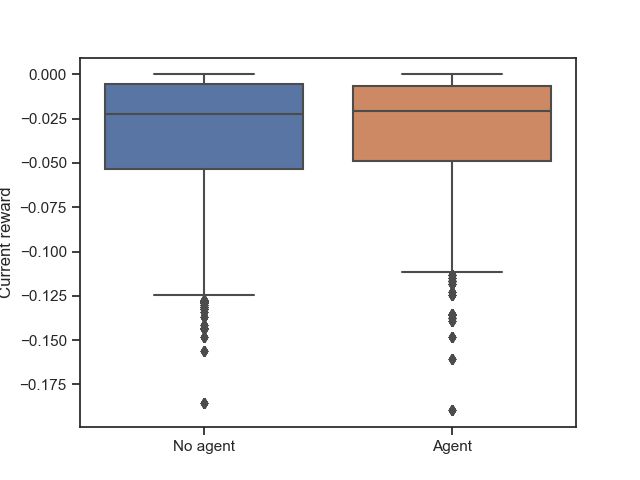

Text(0, 0.5, 'Current reward')

In [250]:
fig, ax = plt.subplots()
sns.boxplot(x="", y="Reward", data=rewards, ax=ax)
ax.set_ylabel('Current reward')

In [186]:
#pickle_savefig(fig,'config1_100ep_boxplot_current')

## Period the agent is good

<IPython.core.display.Javascript object>


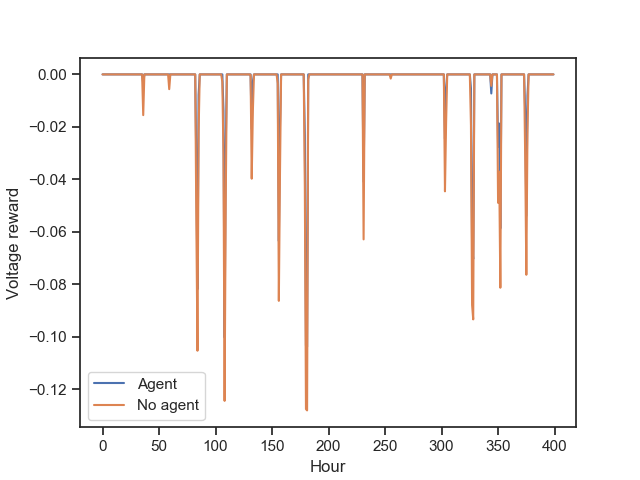

Text(0.5, 0, 'Hour')

In [251]:
rewards = df[df[''].isin(['Agent','No agent'])] #voltage: (15600,16000)
data = rewards
data = data[data['Hours'].isin(range(15600,16000))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=15600))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='')
ax.set_ylabel('Voltage reward')
ax.set_xlabel('Hour')

In [199]:
#pickle_savefig(fig,'config1_400hour_good_voltage')

In [252]:
#stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats  = data[['','Reward']].groupby([''])['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_400hour_good_voltage.csv',float_format='%.3f')


,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,400.0,-0.002516,0.012521,-0.103773,0.0,0.0,0.0,0.0
No agent,400.0,-0.003809,0.016900,-0.127999,0.0,0.0,0.0,0.0


## Periods the agent is bad in terms of voltage
The agent has not learned to cope with high solar power production, period with high solar production have been found manually

<IPython.core.display.Javascript object>


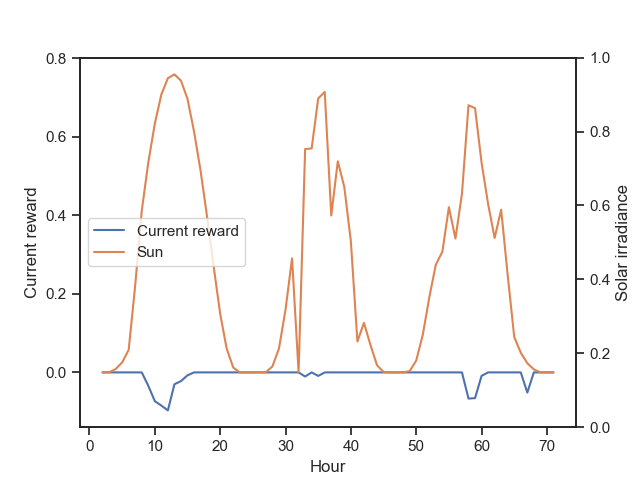

Text(0, 0.5, 'Solar irradiance')

In [253]:
rewards = df[df[''].isin(['Agent','Sun'])] #current (14570,14640), voltage (9800,9950)
data = rewards
data = data[data['Hours'].isin(range(14570,14640))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=14568))
data[''] = data[''].apply(lambda x: 'Current reward' if x == 'Agent' else x)
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='')
ax.set_ylabel('Current reward')
ax.set_xlabel('Hour')
ax2 = plt.twinx()
ax2.set_ylabel('Solar irradiance')

In [193]:
#pickle_savefig(fig,'config1_bad_current')


In [254]:
stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_150hour_bad_voltage.csv',float_format='%.3f')

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Current reward,14.0,-0.039984,0.032464,-0.096699,-0.066309,-0.032039,-0.009327,-0.000107


## Distribution in critical hours

In [332]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] < 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])

<IPython.core.display.Javascript object>


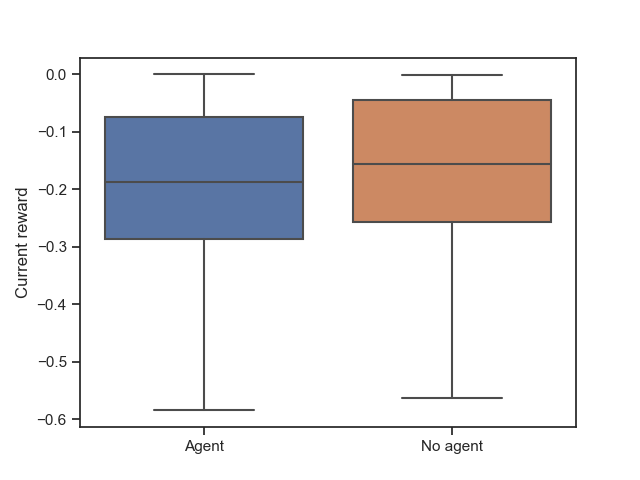

Text(0, 0.5, 'Current reward')

In [334]:
stacked = stack_columns(bad_agent,['Agent', 'No agent'])
fig, ax = plt.subplots()
sns.boxplot(x='', y="Reward", data=stacked, ax=ax)
ax.set_ylabel('Current reward')

In [335]:
#pickle_savefig(fig, 'config1_current_boxplot')

In [43]:
 (118.3-115.7) /118.3

0.02197802197802193

In [292]:
stats = stacked.groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_voltage_critical.csv',float_format='%.3f')


## T-test to see find difference

In [258]:
cat1 = bad_agent['Agent']
cat2 = bad_agent['No agent']
wilcoxon(cat1, cat2)

WilcoxonResult(statistic=9979077.0, pvalue=7.212953509263093e-298)

## Sort rewards of the agent

<IPython.core.display.Javascript object>


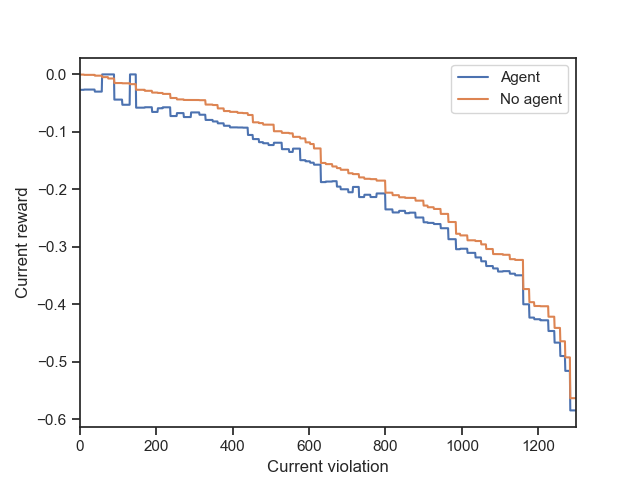

Text(0, 0.5, 'Current reward')

In [336]:
fig, ax = plt.subplots()
sorted_agent = bad_agent.sort_values(by='No agent',ascending=False)
sorted_agent = sorted_agent.reset_index()
sorted_agent.plot(y=['Agent','No agent'],ax=ax)
ax.set_xlabel('Current violation')
ax.set_ylabel('Current reward')

In [337]:
#pickle_savefig(fig,'config1_sorted_current')

In [58]:
data.quantile(0.86)

Reward              0.424817
Hours              61.540000
Hour in the day    20.000000
Name: 0.86, dtype: float64

In [338]:
data = sorted_agent[['Agent','No agent']]
data[data['Agent'] > data['No agent']].describe()

,Agent,No agent
count,48.0,48.000000
mean,0.0,-0.009607
std,0.0,0.005349
min,-0.0,-0.016965
25%,-0.0,-0.016965
50%,-0.0,-0.007120
75%,-0.0,-0.004737
max,-0.0,-0.004737


In [307]:
1- 0.022934/0.036768

0.37625108790252393

In [339]:
(data['Agent'] < data['No agent']).mean()

0.963076923076923

<IPython.core.display.Javascript object>


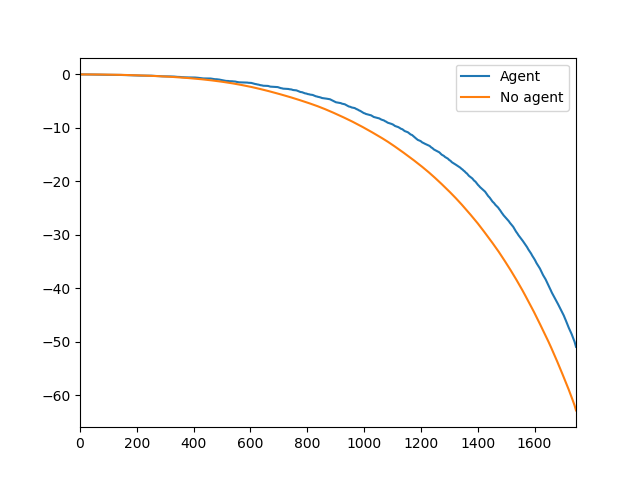

In [61]:
data.cumsum().plot()

## Trained agent in non-critical periods

<IPython.core.display.Javascript object>


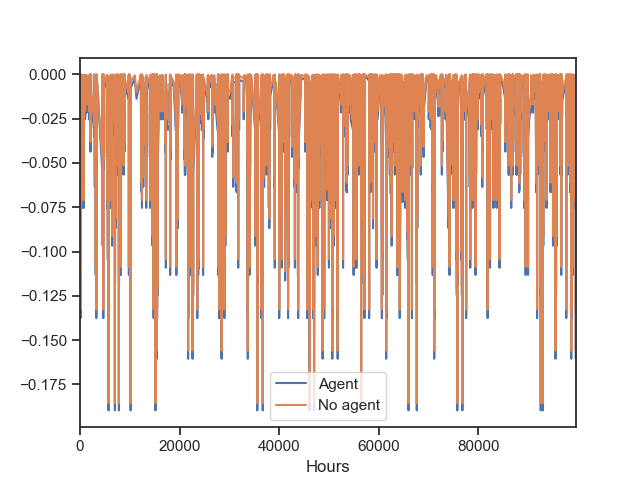

In [262]:
agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
data = agent[['Hours']].reset_index(drop=True)
data['Agent'] = agent['Reward'].values
data['No agent'] = normal['Reward'].values
assert all(data['Hours'].values == normal['Hours'].values)

worse = data[data['Agent'] < data['No agent']]
worse.plot(x='Hours')

In [263]:
(normal['Reward'] == 0).mean()

0.9140691406914069

## Non critical hours when the normal operation give no penalty
Most of the time the safety margins are not violated. How is the trained agent behaving in these hours?

In [317]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] == 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])
data = bad_agent[['Agent','No agent']]

<IPython.core.display.Javascript object>


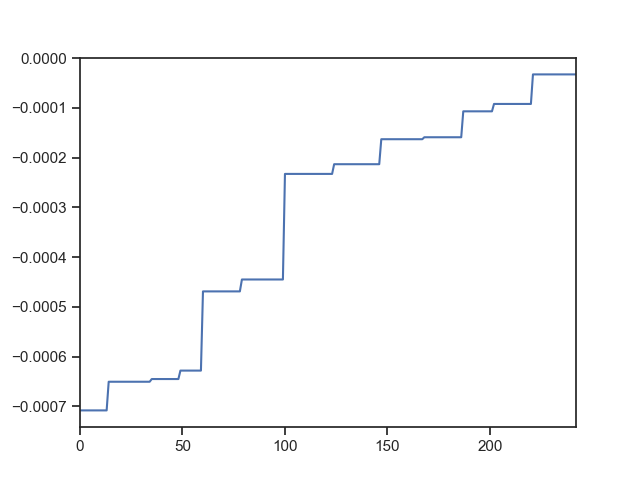

In [319]:
fig, ax = plt.subplots()
data[data['Agent'] < data['No agent']]['Agent'].sort_values().reset_index(drop=True).plot()

In [314]:
no_agent.groupby(no_agent['Reward'] < 0)['Reward'].describe()

,count,mean,std,min,25%,50%,75%,max
Reward,,,,,,,,
False,91406.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
True,8593.0,-0.035439,0.036929,-0.185599,-0.053629,-0.022419,-0.005713,-0.000016


In [316]:
1-8593/(91406 + 8593)

0.9140691406914069

<IPython.core.display.Javascript object>


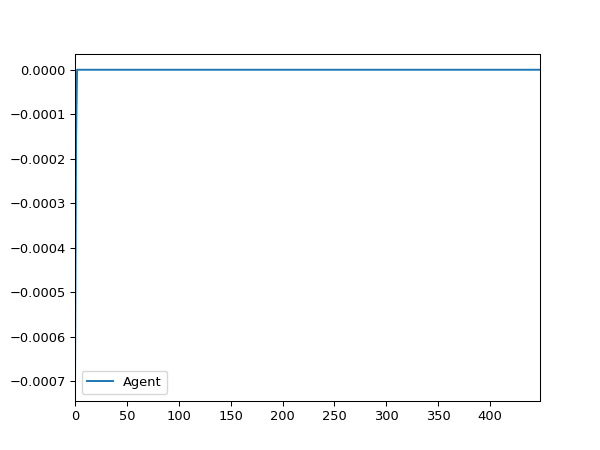

In [82]:
bad_agent[['Agent','No agent']].sort_values(by='Agent').reset_index().plot(y='Agent')

In [320]:
bad_agent[bad_agent['Agent'] < 0].describe()

,Agent,Hours,Hour in the day,No agent,normal_hours
count,243.000000,243.000000,243.000000,243.0,243.000000
mean,-0.000324,54596.868313,12.522634,0.0,54596.868313
std,0.000228,29564.120660,1.420955,0.0,29564.120660
min,-0.000708,22.000000,10.000000,0.0,22.000000
25%,-0.000469,29649.500000,11.000000,0.0,29649.500000
50%,-0.000233,58135.000000,13.000000,0.0,58135.000000
75%,-0.000159,80715.000000,13.000000,0.0,80715.000000
max,-0.000033,99567.000000,15.000000,0.0,99567.000000


In [321]:
243/91406

0.0026584688094873424

## Plot error by hour of the day
make boxplot for each hour of the day that show error distribution

In [341]:
agent = df[df[''] =='Agent']
no_agent = df[df[''] =='No agent']
bad_normal = no_agent[no_agent['Reward'] < 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]

<IPython.core.display.Javascript object>


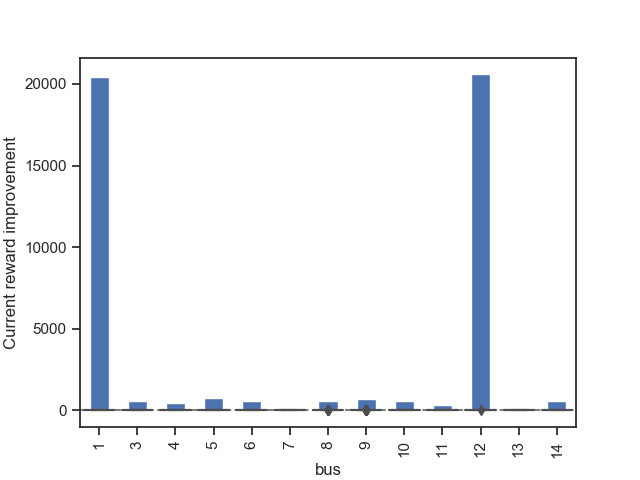

Text(0, 0.5, 'Current reward improvement')

In [343]:
assert all(bad_agent['Hours'].values == bad_normal['Hours'].values)
diff = pd.DataFrame()
diff['Improvement'] = bad_agent['Reward'].values - bad_normal['Reward'].values
diff['Hour'] = bad_agent['Hour in the day'].values
zero_data = []
for h in range(7,24):
    if h not in set(diff['Hour']):
        zero_data.append({'Hour':h,'Improvement':0})

if len(zero_data) > 0:
    diff = diff.append(zero_data)


fig, axes = plt.subplots()
sns.boxplot(x='Hour', y="Improvement", data=diff, ax=axes, color='grey')
axes.axhline(0,c=".5",ls='--')
axes.set_xlim(3) #V: 6.4,21.6
axes.set_xlabel('Hour of the day')
axes.set_ylabel('Current reward improvement')


In [344]:
diff.groupby(by='Hour').describe()

Improvement                                                              \
           count      mean       std       min       25%       50%       75%   
Hour                                                                           
0            1.0 -0.026502       NaN -0.026502 -0.026502 -0.026502 -0.026502   
5            1.0 -0.024438       NaN -0.024438 -0.024438 -0.024438 -0.024438   
7            2.0 -0.024779  0.004990 -0.028308 -0.026543 -0.024779 -0.023015   
8            1.0  0.000000       NaN  0.000000  0.000000  0.000000  0.000000   
9            1.0  0.000000       NaN  0.000000  0.000000  0.000000  0.000000   
10         121.0 -0.022702  0.001981 -0.025444 -0.023828 -0.023318 -0.020486   
11         226.0 -0.025116  0.002682 -0.032427 -0.026240 -0.025299 -0.023012   
12         307.0 -0.027388  0.002989 -0.034216 -0.028999 -0.026856 -0.026514   
13         365.0 -0.028880  0.003432 -0.037879 -0.031136 -0.028598 -0.025618   
14         208.0 -0.031032  0.003428 -0.037390 -0.033205 -0.031149 -0.029100   
15          16.0 -0.033164  0.002097 -0.033688 -0.033688 -0.033688 -0.033688   
16           1.0 -0.026653       NaN -0.026653 -0.026653 -0.026653 -0.026653   
17           1.0  0.000000       NaN  0.000000  0.000000  0.000000  0.000000   
18           1.0 -0.025634       NaN -0.025634 -0.025634 -0.025634 -0.025634   
19           1.0  0.000000       NaN  0.000000  0.000000  0.000000  0.000000   
20          33.0  0.010697  0.009164 -0.032361  0.007120  0.007120  0.016965   
21          16.0  0.004737  0.000000  0.004737  0.004737  0.004737  0.004737   
22           1.0 -0.037390       NaN -0.037390 -0.037390 -0.037390 -0.037390   
23           1.0 -0.029750       NaN -0.029750 -0.029750 -0.029750 -0.029750   

                
           max  
Hour            
0    -0.026502  
5    -0.024438  
7    -0.021250  
8     0.000000  
9     0.000000  
10   -0.019998  
11   -0.021587  
12   -0.021250  
13   -0.024438  
14   -0.023643  
15   -0.025299  
16   -0.026653  
17    0.000000  
18   -0.025634  
19    0.000000  
20    0.016965  
21    0.004737  
22   -0.037390  
23   -0.029750

In [345]:
#pickle_savefig(fig,'config1_improvement_current')

## Nominal load values
See the difference in nominal loads between the loads

<IPython.core.display.Javascript object>


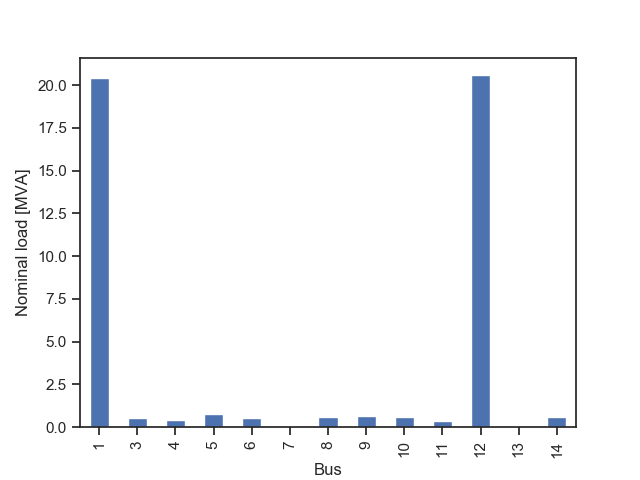

Text(0.5, 0, 'Bus')

In [465]:
fig,ax = plt.subplots()
net = env.powergrid
nominal_load = net.load[['name','bus','sn_kva']]
nominal_load = nominal_load.groupby('bus').sum()
nominal_load['Load share'] = nominal_load['sn_kva'] / nominal_load['sn_kva'].sum() * 100
nominal_load['sn_kva'] = nominal_load['sn_kva'].astype('int')
nominal_load['sn_kva'] /= 1000
nominal_load['sn_kva'].plot(kind='bar', ax=ax)
ax.set_ylabel('Nominal load [MVA]')
ax.set_xlabel('Bus')

#nominal_load.to_csv('data/nominal_load.csv',float_format='%.1f')
#pickle_savefig(fig,'nominal_load')

## Nominal sgen values
See the difference in nominal loads between the loads

<IPython.core.display.Javascript object>


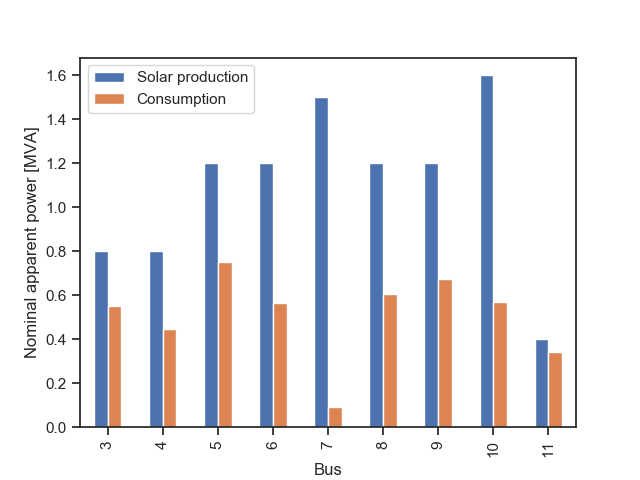

In [477]:
fig,ax = plt.subplots()
net = env.powergrid
nominal_sgen = net.sgen[['name','bus','sn_kva']]
nominal_sgen = nominal_sgen.groupby('bus').sum()
nominal_sgen['Load share'] = nominal_sgen['sn_kva'] / nominal_sgen['sn_kva'].sum() * 100
nominal_sgen['Solar production'] = nominal_sgen['sn_kva'].astype('int')
nominal_sgen['Solar production'] /= 1000
nominal_sgen['Consumption'] = nominal_load['sn_kva']
nominal_sgen[['Solar production','Consumption']].plot(kind='bar', ax=ax)
ax.set_ylabel('Nominal apparent power [MVA]')
ax.set_xlabel('Bus')

#nominal_load.to_csv('data/nominal_sgen.csv',float_format='%.1f')
#pickle_savefig(fig,'nominal_sgen')